<a href="https://colab.research.google.com/github/pj0620/google-colab-notebooks/blob/main/photocircuit_poc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extract Circuit Images

In [31]:
def draw_image(image):
  plt.figure(figsize=(12, 16))
  plt.imshow(image, cmap='gray')
  plt.axis('off')
  plt.show()

### Imports

In [ ]:
!apt-get install -y poppler-utils
!pip install PyPDF2 pytesseract pdf2image opencv-python-headless


In [21]:
from PyPDF2 import PdfReader
import cv2
import pytesseract
from pdf2image import convert_from_path
import os
import matplotlib.pyplot as plt
import numpy as np

### Save as Images

In [25]:
def convert_pdf_to_images(pdf_path, start_page, end_page):
    images = []
    with open(pdf_path, 'rb') as file:
        reader = PdfReader(file)
        for page_num in range(start_page - 1, end_page):
            if reader.is_encrypted:
                reader.decrypt('')
            page = reader.pages[page_num]
            images += convert_from_path(pdf_path, first_page=page_num + 1, last_page=page_num + 1, fmt='jpeg')
    return images

book_pdf_path = '/content/drive/MyDrive/Photo Circuit/Fundamentals_of_Electric_Circuits_6th_Sadiku.pdf'
# pages_all = convert_pdf_to_images(book_pdf_path, 390, 575)
pages_pil = convert_pdf_to_images(book_pdf_path, 462, 476)
images = [np.array(pil_image) for pil_image in pages_pil]  # Convert PIL images to NumPy arrays
pages = [cv2.cvtColor(image, cv2.COLOR_GRAY2BGR) if image.ndim == 2 else image for image in images]  # Convert grayscale images to BGR


In [ ]:
# Assuming you have already run the main() function
first_page_image = pages_pil[0]
draw_image(first_page_image)

### Get Contours

In [53]:
def find_contours(image, kernel_size=3, threshold=100):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (kernel_size, kernel_size), 0)

    # Perform Sobel edge detection
    sobel_x = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobel_y = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=kernel_size)
    sobel_magnitude = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
    sobel_magnitude = np.uint8(sobel_magnitude / np.max(sobel_magnitude) * 255)

    # Threshold the Sobel magnitude to create a binary image
    _, binary_image = cv2.threshold(sobel_magnitude, threshold, 255, cv2.THRESH_BINARY)

    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    return contours



contours = [find_contours(page) for page in pages]

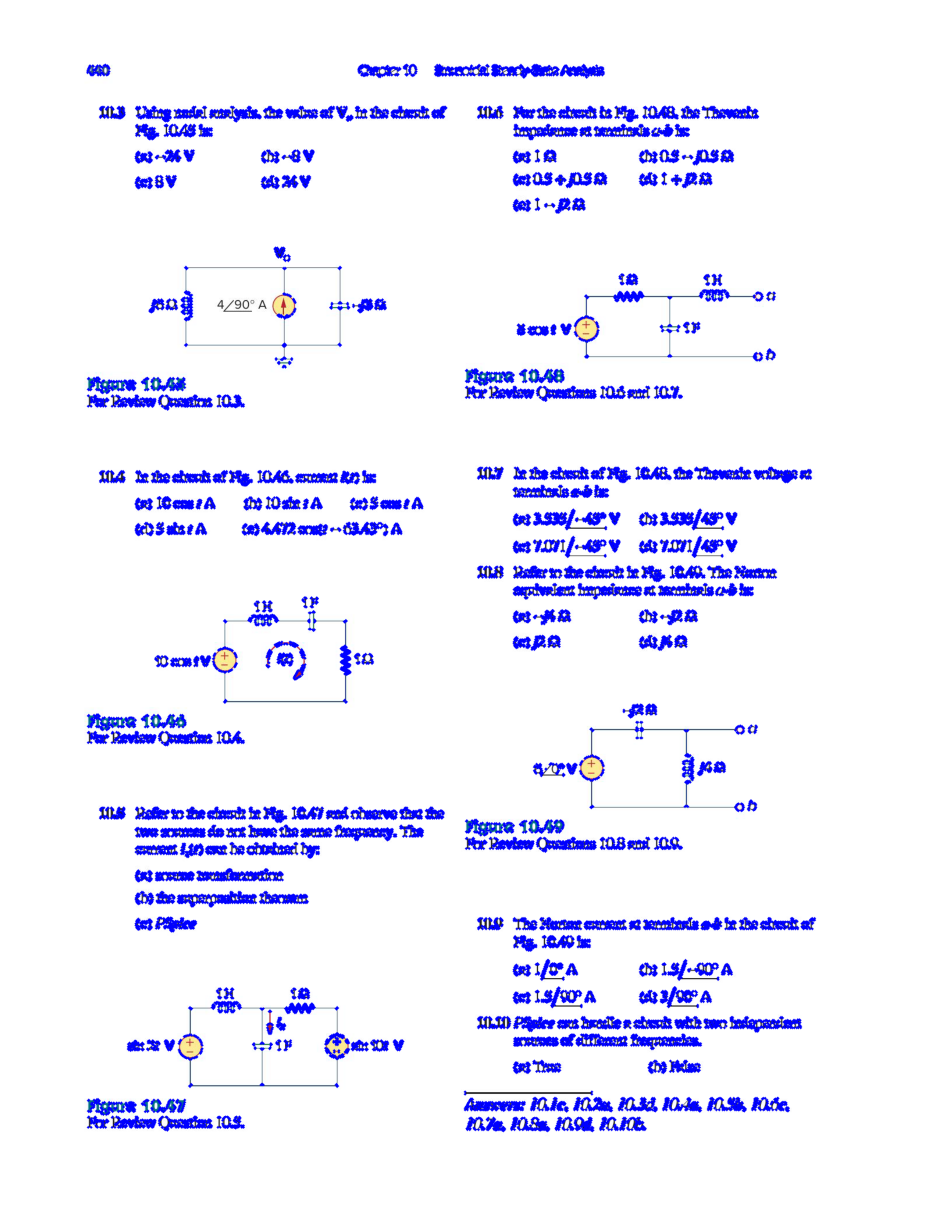

In [54]:
image_with_dots = images[1].copy()
dot_radius=2
color=(0, 0, 255)
for contour in contours[1]:
    for point in contour:
        x, y = point[0]
        cv2.circle(image_with_dots, (x, y), dot_radius, color, -1)
draw_image(image_with_dots)

## Get Bounding Boxes

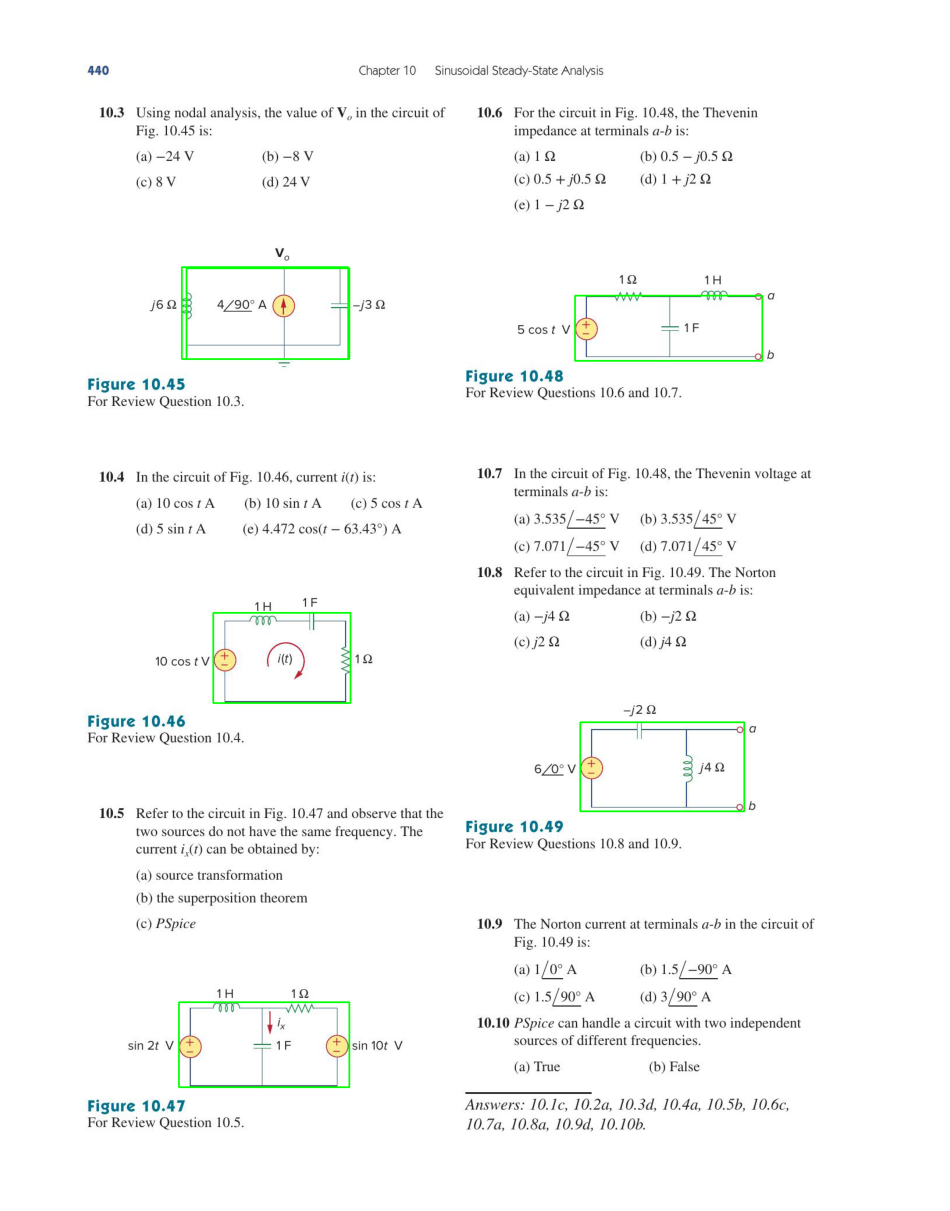

In [57]:
def draw_bounding_boxes(image, bounding_boxes, color=(0, 255, 0), thickness=2):
    image_with_boxes = image.copy()
    for x, y, w, h in bounding_boxes:
        cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), color, thickness)
    return image_with_boxes

def get_bounding_boxes(contours, min_length):
    for i, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)

        if w < min_length or h < min_length:
          continue

        yield (x, y, w, h)


min_length = images[0].shape[1] * 0.05
bounding_boxes = [get_bounding_boxes(contour, min_length) for contour in contours]
images_with_boxes = [draw_bounding_boxes(images[i], bounding_boxes[i]) for i in range(len(images))]

draw_image(images_with_boxes[1])
        